In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from src.tag_grouper import TagGrouper

# Import the data around COP21

In [2]:
file_name = 'data/climate_videos.jsonl'
df = pd.read_json(file_name, lines=True)
df['upload_date'] = pd.to_datetime(df['upload_date'])
df.set_index('upload_date', inplace=True)
df.sort_index(inplace=True)
df = df.loc['2015-12-01': '2015-12-31']

df.reset_index(inplace=True)
df.set_index('display_id', inplace=True)
df.head()

,upload_date,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,view_count
display_id,,,,,,,,,,,
jD-Xa_vpaeM,2015-12-01,Nonprofits & Activism,UCFnB6jXxfLsD3CmNIZ8iYCg,2019-10-30 07:17:46.166349,One Young World delegate Tarek Yassine calls o...,1.0,162,5.0,"Kuwait (Country),Call On COP,COP21,Gulf Region...","#CallOnCOP - Tarek Yassine, Kuwait",407.0
J863_OEXZ74,2015-12-01,News & Politics,UC7fWeaHhqgM4Ry-RMpM2YYw,2019-11-05 01:11:51.180884,,0.0,201,3.0,,TRT World - Interview with Ibrahim Thiaw about...,348.0
-cPFW7pIxzw,2015-12-01,News & Politics,UC9jj-YYSGUXvY2J2nYw9dNQ,2019-11-01 19:59:50.968433,More than 140 world leaders gathered for that ...,1.0,184,7.0,"mashable,video,Climate Summit,United Nations (...",The Most Powerful Climate Quotes From the Firs...,780.0
_W4BtX5yRXI,2015-12-01,News & Politics,UC7fWeaHhqgM4Ry-RMpM2YYw,2019-11-05 01:11:51.739916,Turkey ‘to continue fight against Daesh’\nPrim...,0.0,151,3.0,,"TRT World - World in Two Minutes, 2015, Decemb...",181.0
zGjIXBffIrY,2015-12-01,News & Politics,UC7fWeaHhqgM4Ry-RMpM2YYw,2019-11-05 01:11:53.792168,Erdogan rejects Daesh oil accusations\nPreside...,0.0,150,2.0,"Recep Tayyip Erdoğan (Politician),Turkey (Coun...","TRT World - World in Two Minutes, 2015, Decemb...",262.0


# Initial transformation and filtering on the tags

In [3]:
data = df['tags'].copy()
tag_grouper = TagGrouper()

tqdm.pandas()
data = data.apply(lambda tags: tags.split(','))
data = data.progress_apply(lambda tags: [tag_grouper.get(tag) for tag in tags if tag != ''])
data = data[data.apply(lambda tags: len(tags) > 0)]
data

100%|██████████| 1938/1938 [00:50<00:00, 38.69it/s]


display_id
jD-Xa_vpaeM    [kuwait (country), call on cop, cop21, gulf re...
-cPFW7pIxzw    [mashable, video, summit, united nations (memb...
zGjIXBffIrY    [recep tayyip erdoğan (politician), kuwait (co...
Yzispq9PdYc    [justin trudeau, paris, saskatchewan premier, ...
hFwx7W-lx5w    [racing extinction, kuwait (country), louie ps...
                                     ...                        
8V0t57Ts2Aw    [hghhhh, fast radio burst, gggggh, shave essen...
g98O4gx5TdM    [harvard, books, ap online, brad wall, jhaadu ...
ZBORnsSlcAs    [german wind power, south africa, education, d...
8pKAlDn0MdA    [indian democracy, amy goodman, dn, fox news, ...
sxJo1s4LAWg    [prime time, entertainment news, displaced peo...
Name: tags, Length: 1794, dtype: object

# Take a look at the tag counts

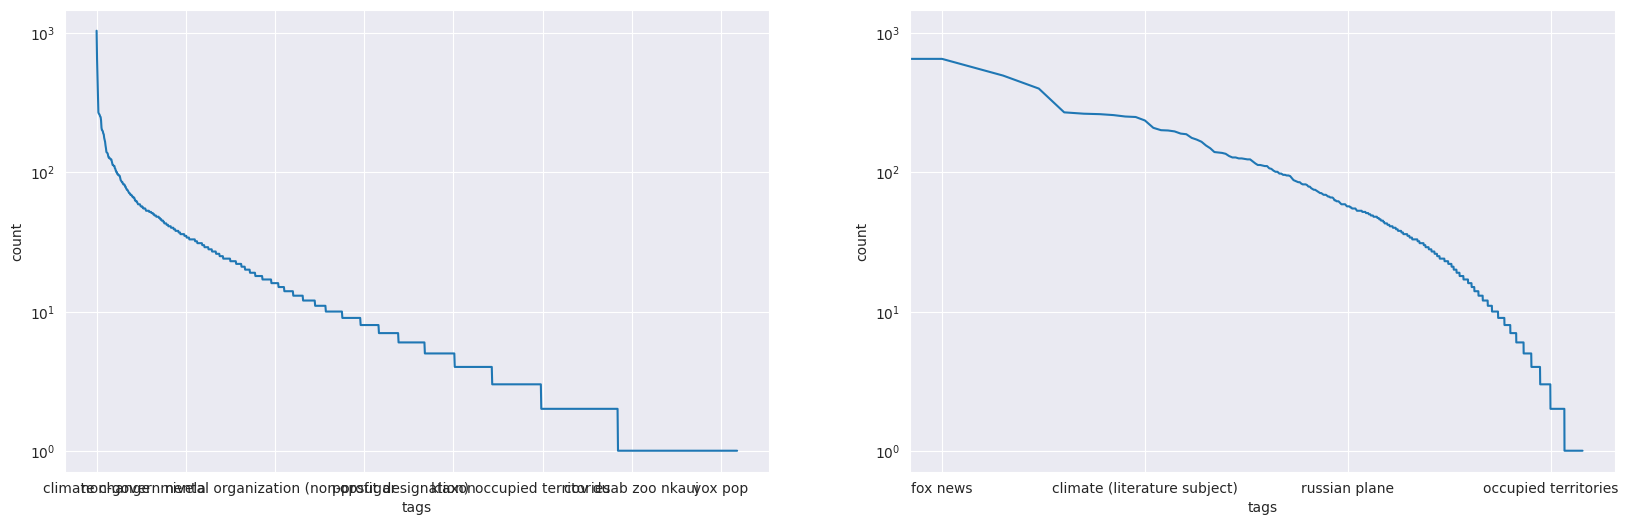

climate change                     1042
fox news                            654
education                           496
cop21                               400
politics (tv genre)                 270
                                   ... 
入尾信充                                  1
d.i.y.                                1
jesuslostchildren777                  1
our lady of guadalupe (artwork)       1
banjul                                1
Length: 1437, dtype: int64

In [4]:
tags_count = pd.Series(dict(Counter(tag for tags in data for tag in tags)))
tags_count.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True)
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True)
plt.show()
tags_count

# Only keep the top 90th percentile of tags 

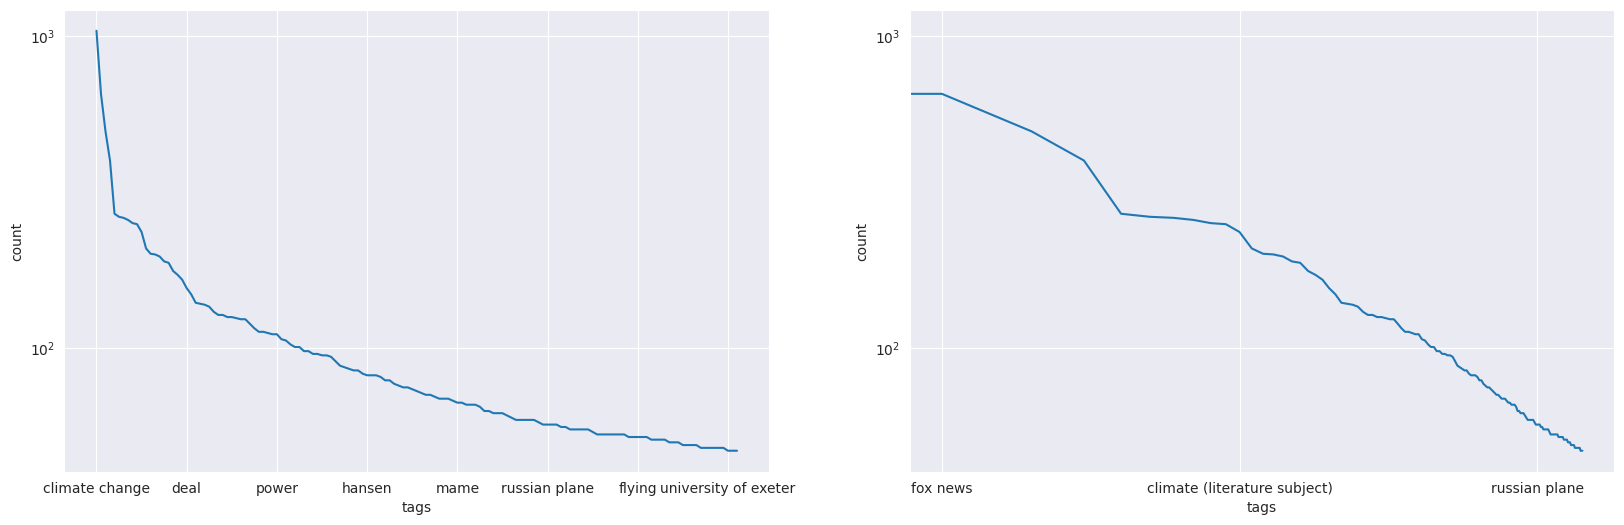

climate change                 1042
fox news                        654
education                       496
cop21                           400
politics (tv genre)             270
                               ... 
msnbc                            48
fossil free berlin               48
university of exeter             47
school system                    47
al gore (us vice president)      47
Length: 143, dtype: int64

In [5]:
threshold = tags_count.quantile(0.9)
common_tags_count = tags_count[tags_count > threshold]
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True)
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True)
plt.show()
common_tags_count

# Filter the tags in the dataframe

In [6]:
videos = list(data.index)
common_tags = set(common_tags_count.index)
data = data.apply(lambda x: [tag for tag in x if tag in common_tags])

# Create the bipartite graph between videos and tags

In [7]:
G = nx.Graph()
G.add_nodes_from(common_tags, bipartite=0)
G.add_nodes_from(videos, bipartite=1)

for video, tags in tqdm(data.items(), total=len(data)):
    for tag in tags:
        G.add_edge(video, tag)
print(G)

100%|██████████| 1794/1794 [00:00<00:00, 64960.60it/s]

Graph with 1937 nodes and 12830 edges


# Project the graph onto the videos

Graph with 19 nodes and 21 edges


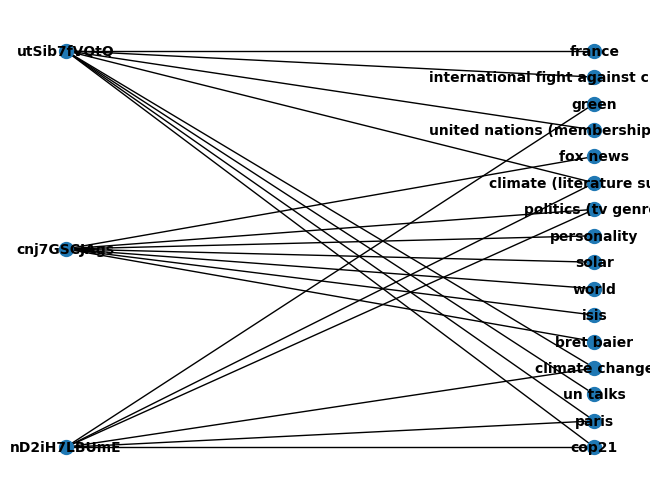

In [8]:
sub_videos = videos[8:11].copy()
sub_tags = []
for node in sub_videos:
    sub_tags.extend(list(G.neighbors(node)))
    
sub_nodes = sub_videos + sub_tags
subgraph = G.subgraph(sub_nodes)
print(subgraph)
pos = nx.bipartite_layout(subgraph, nodes=sub_videos, scale=1, aspect_ratio=4/3)  # Set the layout for bipartite graphs
nx.draw(subgraph, with_labels=True, pos=pos, node_size=100, font_size=10, font_weight='bold')

# Project the graph onto the tags

In [9]:
print("Start")
tag_graph = nx.bipartite.weighted_projected_graph(G, common_tags, ratio=True)
print(tag_graph)

Start
Graph with 143 nodes and 8381 edges


In [10]:
edges = tag_graph.edges.data('weight')
threshold = np.percentile([w for _, _, w in edges], 99.5)
filtered_edges = [(u, v, w) for u, v, w in edges if w > threshold]

filtered_graph = nx.Graph()  
filtered_graph.add_weighted_edges_from(filtered_edges)
print(filtered_graph)

Graph with 20 nodes and 42 edges


[16  1  1  4  3  1  6  9  2  3  4  1  2  3  4 14  5  3  1  1]


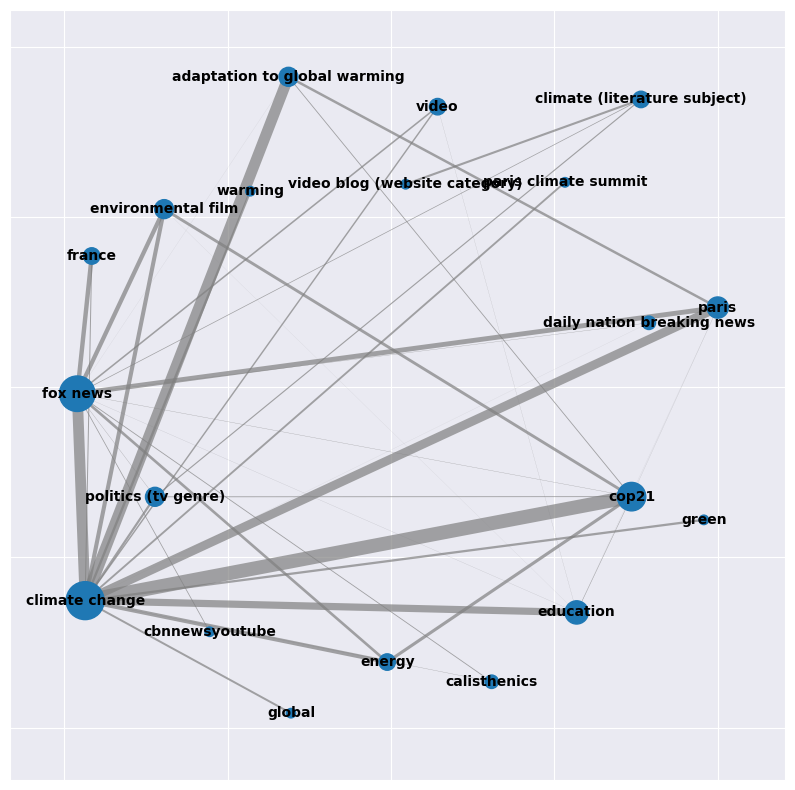

In [11]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(filtered_graph, k=1.1, iterations=20)  # Set the layout for bipartite graphs

weights = np.array([w for _, _, w in filtered_edges])
weights = (weights - weights.min()) / (weights.max() - weights.min()) * 10  

degrees = np.array([d for _, d in filtered_graph.degree()]) 
print(degrees)
degrees = degrees / (degrees.max() - degrees.min()) * 700   # Min max normalize the degrees

nx.draw_networkx_nodes(filtered_graph, pos, node_size=degrees)
nx.draw_networkx_edges(filtered_graph, pos, width=weights, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(filtered_graph, pos, font_size=10, font_weight='bold')
plt.show()